In [2]:
import os
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch.nn as nn

import sys
sys.path.append("..")
from hsvit.preprocessor import preprocess_pipeline
from hsvit.hooks import FeatureHook

In [3]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stage1(x)   # Hook here
        x = self.stage2(x)
        return x

In [4]:
mat_files = sorted(glob("/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/*.mat"))

with h5py.File(mat_files[0], 'r') as f:
    image = np.array(f['cjdata']['image']).T

In [5]:
preprocessed = preprocess_pipeline(image)
input_tensor = torch.tensor(preprocessed / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

In [6]:
model = DummyEncoder()
model.eval()
hook = FeatureHook(model.stage1[0])

In [7]:
with torch.no_grad():
    _ = model(input_tensor)

In [8]:
features = hook.features.squeeze(0)  # [C, H, W]
hook.close()

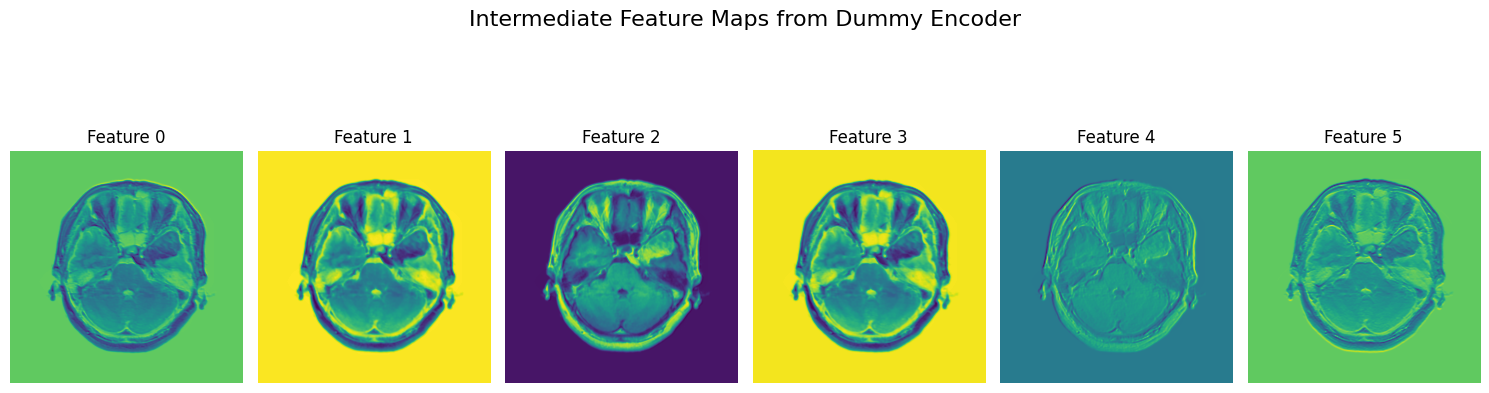

In [9]:
num_maps = min(6, features.shape[0])
plt.figure(figsize=(15, 5))
for i in range(num_maps):
    plt.subplot(1, num_maps, i+1)
    plt.imshow(features[i], cmap='viridis')
    plt.title(f"Feature {i}")
    plt.axis('off')
plt.suptitle("Intermediate Feature Maps from Dummy Encoder", fontsize=16)
plt.tight_layout()
plt.show()